In [70]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import sys

sys.path.append('../scripts')

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from elements import *

import measurement as me

### OMIT
    In this test, the comparison between IOpy calculations and theory is shown in OMIT effect.

### Defining the OM system

In [73]:
omega_cav = 5e9*np.pi*2
kappa_0 = 0.3e5*np.pi*2
kappa_ex = 0.4e5*np.pi*2

omega_m = 5e6*np.pi*2
gamma_m = 100*np.pi*2

g_0 = 200*np.pi*2

P_in = 8e-12
Delta = -omega_m
omega_cont = omega_cav + Delta
T_cont = 1

from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_cav, omega_cont, omega_m, g_0)

g= omdir['g']
omega_cav = omdir['omega_c']


a = Mode('a', omega_cav)
b = Mode('b', omega_m)

a_cont = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_cont, bath_temp = T_cont)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=10e-3)

b_in0 = Input('0', b, gamma_m, kind = 'bath', bath_temp=10e-3)

g_ab = Coupling(a, b, g * np.array([1,0,0,0]))

sys_om = System([a, b], [a_in0, b_in0, a_cont], [g_ab])

a_outex = Output(sys_om, a_cont)
print ('Cooperativity C: ',4*g**2/a.kappa/gamma_m)

Cooperativity C:  14.06827858860801


### Calculating with IOpy

In [74]:
window_width = 0.01 * omega_m
omegas = np.linspace(omega_cav - window_width/2 , omega_cav +  window_width/2 , 1000)
omegas_new, T_IOpy = me.linear_response(omegas, sys_om, a_outex, a_cont, plot = 0)

### Theory

The transmission window is:

$$T = 1 - \kappa_{ext}\frac{\chi_{opt}(\Omega)}{1 + g^2\chi_{omech}(\Omega)\chi_{opt}(\Omega)}$$
Where:
\begin{align}
    \chi_{opt}(\Omega) &= [-i(\Omega+\Delta)+\kappa/2]^{-1}\\
    \chi_{mech}(\Omega) &= [-i(\Omega-\Omega_m)+\Gamma_m/2]^{-1}
\end{align}
With:
$$\Delta = \omega_{cont} - \omega_{cav},\quad \Omega = \omega_p - \omega_{cont}$$


In [78]:
X_opt = (-1j * ((omegas - omega_cont) + (omega_cont - omega_cav)) + a.kappa / 2)**(-1)
X_mech = (-1j *((omegas - omega_cont) - omega_m ) + gamma_m/2)**(-1)
T_theory = 1 - kappa_ex * X_opt / (1 + X_opt * X_mech * g**2)

### Comparison

<IPython.core.display.Javascript object>


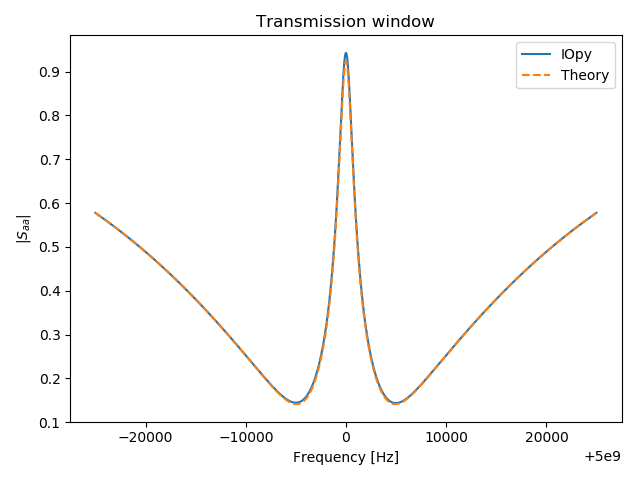

<IPython.core.display.Javascript object>


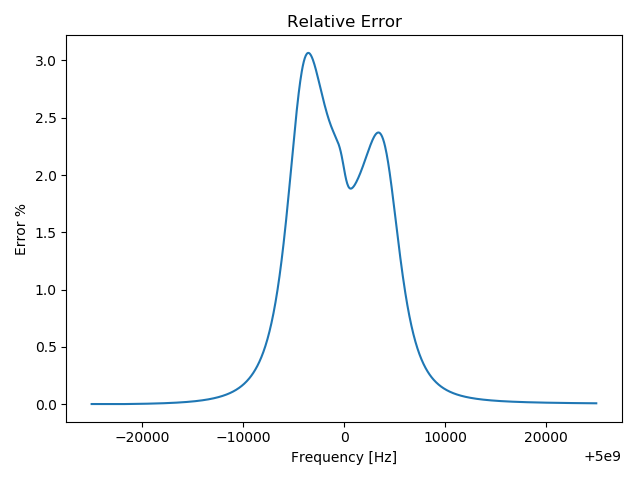

In [79]:
plt.figure()
plt.plot(omegas/2/np.pi, np.abs(T_IOpy), label = 'IOpy')
plt.plot(omegas/2/np.pi, np.abs(T_theory), '--', label = 'Theory')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$|S_{aa}|$')
plt.title('Transmission window')
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(omegas/2/np.pi, 100 * np.abs(np.abs(T_IOpy)-np.abs(T_theory))/np.abs(T_theory))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Error %')
plt.title('Relative Error')
plt.tight_layout()